# Projet 7 : Implémentez un modèle de scoring

## Problématique

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, ...).

L'objectif de ce notebook :

* Choisir les features pertinentes pour la modélisation en se basant sur le kernel EDA précédent de l'analyse exploratoire.
* Choisir les variables numériques suivants les critères suivants:

- choisir les features corrélées avec la variable Target.
- Eviter les features qui sont très corrélées entre elles.
- choisir les features avec un seuil des variables manquantes inférieur à 60 %.
- Créer des nouvelles features pertinentes.

* Choisir les variables catégoriques suivants les critères suivants:

- choisir les features avec un seuil de variables manquantes inférieur à 60 %.
- choisir les features avec le minimum de modes sinon les mapper .
- choisir des features qui ont des relations avec la target en se basant sur l'analyse exploratoire.


## Importation des modules

In [1]:
import pandas as pd 
import numpy as np
import gc
%matplotlib inline
# Settings
import warnings
warnings.filterwarnings('ignore') 

##  Importation de données

In [2]:
PATH='C:/Users/Jess/Desktop/OpenClassrooms/Projet_7/datasets/'

In [3]:
application_train = pd.read_csv(PATH+"/application_train.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

In [4]:
gc.enable()
del application_train,bureau_balance,installments_payments
gc.collect()

0

In [5]:
gc.enable()

### Application train 

In [6]:
application_train = pd.read_csv(PATH+"/application_train.csv")

In [7]:
building_normal_info_list = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE',
'ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI',
'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE' ]

In [8]:
application_train.drop(building_normal_info_list,axis=1,inplace=True)

In [9]:
client_doc = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

In [10]:
application_train.drop(client_doc,axis=1,inplace=True)

In [11]:
AMT_REQ_CREDIT_BUREAU_list = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']

In [12]:
application_train.drop(AMT_REQ_CREDIT_BUREAU_list,axis=1,inplace=True)

In [13]:
social_surroundings_list = ['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
                            'DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']

In [14]:
application_train.drop(social_surroundings_list,axis=1,inplace=True)

In [15]:
application_train.shape

(307511, 48)

In [16]:
external_score_list = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'] #=> !! data leakage !!! 

In [17]:
application_train.drop(external_score_list,axis=1,inplace=True)

In [18]:
application_train.shape

(307511, 45)

In [19]:
Flag_list = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY','LIVE_CITY_NOT_WORK_CITY']

In [20]:
application_train.drop(Flag_list,axis=1,inplace=True)

In [21]:
flag_phone_mail_list = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
'FLAG_PHONE','FLAG_EMAIL']

In [22]:
application_train.drop(flag_phone_mail_list,axis=1,inplace=True)

In [23]:
application_train.shape

(307511, 34)

In [24]:
AMT_list = ['AMT_ANNUITY','AMT_GOODS_PRICE']

In [25]:
application_train.drop(AMT_list,axis=1,inplace=True)

In [26]:
days_list = ['DAYS_REGISTRATION','DAYS_ID_PUBLISH' ]

In [27]:
application_train.drop(days_list,axis=1,inplace=True)

In [28]:
application_train.shape

(307511, 30)

In [29]:
#Family status remapped
dic = {'Single / not married':'not_married', 'Married':'married', 'Civil marriage':'married', 'Widow':'other',
       'Separated':'other', 'Unknown':'other'}
application_train=application_train.replace({"NAME_FAMILY_STATUS": dic})

In [30]:
application_train['NAME_FAMILY_STATUS'].unique()

array(['not_married', 'married', 'other'], dtype=object)

In [31]:
# NAME_INCOME_TYPE remapped
dic = {'Working':'working', 'State servant':'working', 'Commercial associate':'working', 'Pensioner':'working',
       'Unemployed':'not_working', 'Student':'not_working', 'Businessman':'working', 'Maternity leave':'not_working'}
application_train=application_train.replace({"NAME_INCOME_TYPE": dic})

In [32]:
application_train['NAME_INCOME_TYPE'].unique()

array(['working', 'not_working'], dtype=object)

In [33]:
# OCCUPATION_TYPE remapped
dic = {'Laborers':'other', 'Core staff':'other', 'Accountants':'other', 'Managers':'other',
       'Drivers':'other', 'Sales staff':'other', 'Cleaning staff':'other', 'Cooking staff':'other',
       'Private service staff':'other', 'Medicine staff':'other', 'Security staff':'other',
       'High skill tech staff':'other', 'Waiters/barmen staff':'other',
       'Low-skill Laborers':'Low-skill Laborers', 'Realty agents':'other', 'Secretaries':'other', 'IT staff':'other',
       'HR staff':'other'}
application_train=application_train.replace({"OCCUPATION_TYPE": dic})

In [34]:
application_train['OCCUPATION_TYPE'].unique()

array(['other', nan, 'Low-skill Laborers'], dtype=object)

In [35]:
# NAME_EDUCATION_TYPE remapped
dic = {'Secondary / secondary special':'low_educ', 'Higher education':'high_educ',
       'Incomplete higher':'low_educ', 'Lower secondary':'low_educ', 'Academic degree':'high_educ'}
application_train=application_train.replace({"NAME_EDUCATION_TYPE": dic})

In [36]:
application_train['NAME_EDUCATION_TYPE'].unique()

array(['low_educ', 'high_educ'], dtype=object)

In [37]:
#drop not important categ
drop_categories_list = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','ORGANIZATION_TYPE','NAME_HOUSING_TYPE']

In [38]:
application_train.drop(drop_categories_list,axis=1,inplace=True)

In [39]:
application_train.shape

(307511, 26)

In [40]:
gc.collect()

0

In [41]:
df_final = application_train

In [42]:
gc.enable()
del application_train
gc.collect()

0

In [43]:
df_final.shape

(307511, 26)

## bureau_balance

In [44]:
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")

In [45]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [46]:
 df_inter = bureau_balance[bureau_balance['STATUS']!='C']

In [47]:
 df_inter = df_inter[df_inter['STATUS']!='X']

In [48]:
df_inter['STATUS']=df_inter['STATUS'].astype(int)

In [49]:
df_inter = df_inter[df_inter['MONTHS_BALANCE']>-25]

In [50]:
df_grouped = df_inter.groupby(['SK_ID_BUREAU'])['STATUS'].agg(lambda x:x.value_counts().index[0])

In [51]:
bureau_balanced_grouped = pd.DataFrame({'SK_ID_BUREAU':df_grouped.index,'status_most_freq':df_grouped.values})

In [52]:
bureau_balanced_grouped

,SK_ID_BUREAU,status_most_freq
0,5001711,0
1,5001712,0
2,5001717,0
3,5001718,0
4,5001720,0
...,...,...
394422,6842877,0
394423,6842878,0
394424,6842881,0
394425,6842882,0


In [53]:
gc.enable()
del df_inter,bureau_balance,df_grouped
gc.collect()

0

##  Bureau

In [54]:
bureau = pd.read_csv(PATH+"/bureau.csv")

In [55]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [56]:
bureau.shape

(1716428, 17)

In [57]:
bureau_list = ['CREDIT_CURRENCY','CREDIT_DAY_OVERDUE',
'DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM_DEBT',
'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE','AMT_ANNUITY','CREDIT_TYPE']

In [58]:
bureau.drop(bureau_list,axis=1,inplace=True)

In [59]:
bureau = bureau.merge(bureau_balanced_grouped, on = 'SK_ID_BUREAU', how = 'left')

In [60]:
df_grouped = bureau.groupby(['SK_ID_CURR']).agg({'CREDIT_ACTIVE': lambda x:x.value_counts().index[0], 'DAYS_CREDIT': 'mean','AMT_CREDIT_SUM':'mean'})

In [61]:
df_grouped

,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM
SK_ID_CURR,,,
100001,Closed,-735.000000,2.076236e+05
100002,Closed,-874.000000,1.081319e+05
100003,Closed,-1400.750000,2.543501e+05
100004,Closed,-867.000000,9.451890e+04
100005,Active,-190.666667,2.190420e+05
...,...,...,...
456249,Closed,-1667.076923,2.841430e+05
456250,Active,-862.000000,1.028820e+06
456253,Closed,-867.500000,9.900000e+05


In [62]:
bureau_grouped = df_grouped

In [63]:
bureau_grouped.reset_index(inplace=True)

In [64]:
bureau_grouped

,SK_ID_CURR,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM
0,100001,Closed,-735.000000,2.076236e+05
1,100002,Closed,-874.000000,1.081319e+05
2,100003,Closed,-1400.750000,2.543501e+05
3,100004,Closed,-867.000000,9.451890e+04
4,100005,Active,-190.666667,2.190420e+05
...,...,...,...,...
305806,456249,Closed,-1667.076923,2.841430e+05
305807,456250,Active,-862.000000,1.028820e+06
305808,456253,Closed,-867.500000,9.900000e+05
305809,456254,Closed,-1104.000000,4.500000e+04


In [65]:
gc.enable()
del bureau,bureau_balanced_grouped,df_grouped
gc.collect()


0

## credit_card_balance

In [66]:
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")

In [67]:
credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


In [68]:
cols_num = [ 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'SK_DPD',
       'SK_DPD_DEF']

In [69]:
credit_card_balance = credit_card_balance[credit_card_balance['MONTHS_BALANCE']>-13]

In [70]:
l ={}
for c in cols_num:
    l.update({c: 'mean'})

In [71]:
l.update({'NAME_CONTRACT_STATUS': lambda x:x.value_counts().index[0]})

In [72]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [73]:
df_grouped = credit_card_balance.groupby(['SK_ID_CURR']).agg(l)

In [74]:
df_grouped.reset_index(inplace=True)

In [75]:
df_to_corr = df_grouped.merge(df_final[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

C:\Users\Jess\AppData\Local\Temp\ipykernel_28580\3291428710.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_to_corr.corr()


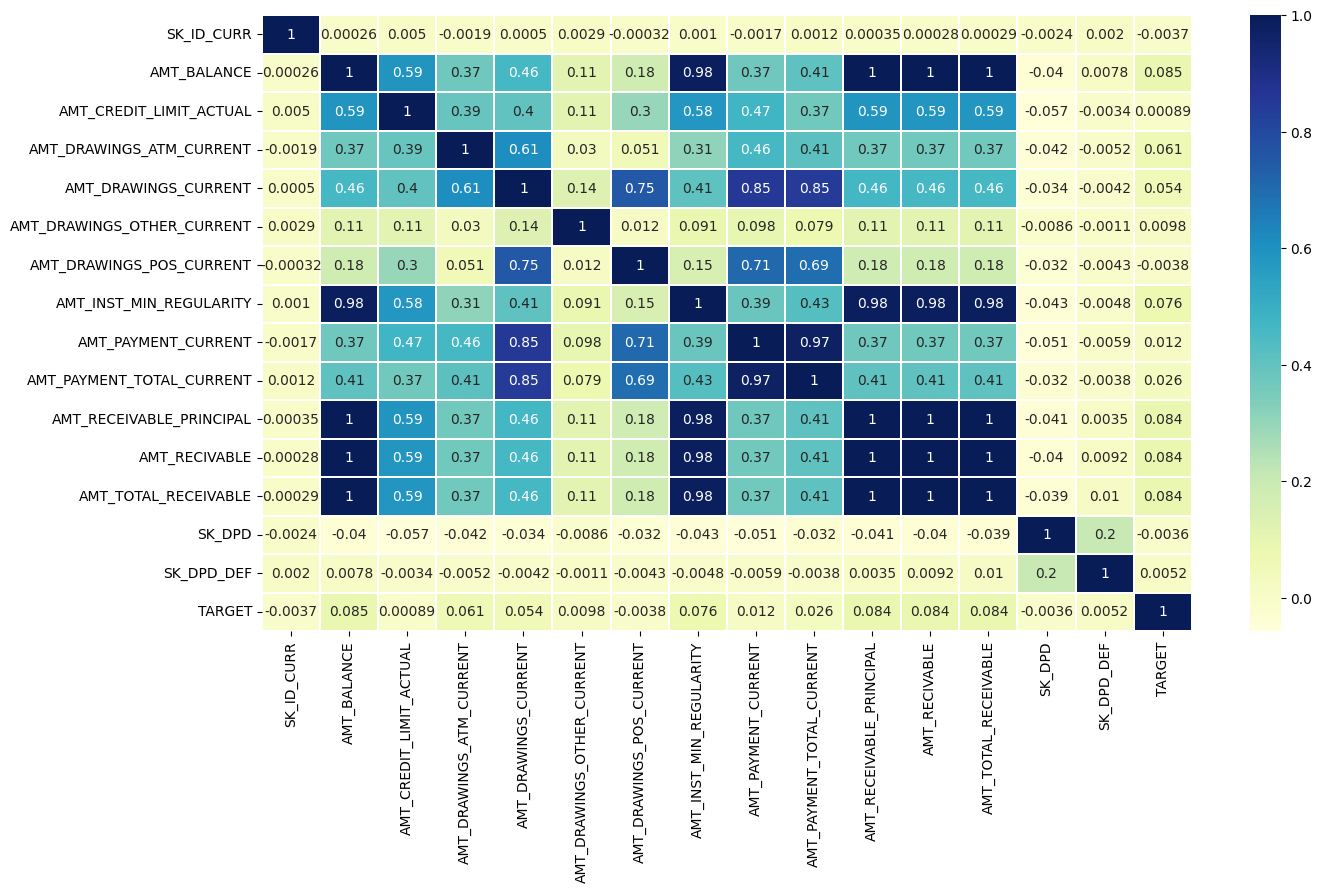

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df_to_corr.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr , annot=True, linewidths=.2, cmap="YlGnBu");

In [77]:
selected_columns= ['SK_ID_CURR','AMT_BALANCE','AMT_PAYMENT_CURRENT','SK_DPD','SK_DPD_DEF']

In [78]:
df_grouped= df_grouped[selected_columns]

In [79]:
credit_card_balance_grouped = df_grouped

In [80]:
gc.enable()
del credit_card_balance,df_grouped
gc.collect()

23130

In [81]:
credit_card_balance_grouped

,SK_ID_CURR,AMT_BALANCE,AMT_PAYMENT_CURRENT,SK_DPD,SK_DPD_DEF
0,100006,0.000000,NaN,0.0,0.0
1,100011,0.000000,563.355,0.0,0.0
2,100013,0.000000,274.320,0.0,0.0
3,100021,0.000000,NaN,0.0,0.0
4,100023,0.000000,NaN,0.0,0.0
...,...,...,...,...,...
103553,456244,0.000000,89.985,0.0,0.0
103554,456246,13136.731875,18778.275,0.0,0.0
103555,456247,0.000000,520.605,0.0,0.0
103556,456248,0.000000,NaN,0.0,0.0


## installments_payments

In [82]:
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")

In [83]:
installments_payments.shape

(13605401, 8)

In [84]:
installments_payments.drop(['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','SK_ID_PREV'],axis=1,inplace=True)

In [85]:
installments_payments

,SK_ID_CURR,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,161674,-1180.0,-1187.0,6948.360,6948.360
1,151639,-2156.0,-2156.0,1716.525,1716.525
2,193053,-63.0,-63.0,25425.000,25425.000
3,199697,-2418.0,-2426.0,24350.130,24350.130
4,167756,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...
13605396,428057,-1624.0,NaN,67.500,NaN
13605397,414406,-1539.0,NaN,67.500,NaN
13605398,402199,-7.0,NaN,43737.435,NaN
13605399,409297,-1986.0,NaN,67.500,NaN


In [86]:
installments_payments = installments_payments[installments_payments['DAYS_INSTALMENT']>2*-365]

In [87]:
installments_payments['DAYS_INSTALMENT_delay'] = installments_payments['DAYS_ENTRY_PAYMENT']-installments_payments['DAYS_INSTALMENT']

C:\Users\Jess\AppData\Local\Temp\ipykernel_28580\2291266123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  installments_payments['DAYS_INSTALMENT_delay'] = installments_payments['DAYS_ENTRY_PAYMENT']-installments_payments['DAYS_INSTALMENT']


In [88]:
installments_payments['AMT_INSTALMENT_delta'] = installments_payments['AMT_PAYMENT']-installments_payments['AMT_INSTALMENT']

C:\Users\Jess\AppData\Local\Temp\ipykernel_28580\2776572029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  installments_payments['AMT_INSTALMENT_delta'] = installments_payments['AMT_PAYMENT']-installments_payments['AMT_INSTALMENT']


In [89]:
installments_payments.drop(['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_PAYMENT','AMT_INSTALMENT'],axis=1,inplace=True)

C:\Users\Jess\AppData\Local\Temp\ipykernel_28580\2713995347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  installments_payments.drop(['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_PAYMENT','AMT_INSTALMENT'],axis=1,inplace=True)


In [90]:
installments_payments

,SK_ID_CURR,DAYS_INSTALMENT_delay,AMT_INSTALMENT_delta
2,193053,0.0,0.0
6,184693,-3.0,0.0
8,112102,0.0,0.0
9,109741,-39.0,0.0
16,170192,-3.0,0.0
...,...,...,...
13605390,450349,NaN,NaN
13605391,418486,NaN,NaN
13605392,434321,NaN,NaN
13605398,402199,NaN,NaN


In [91]:
installments_payments_grouped = installments_payments.groupby(['SK_ID_CURR']).agg({'DAYS_INSTALMENT_delay':'mean','AMT_INSTALMENT_delta':'mean'})

In [92]:
installments_payments_grouped.reset_index(inplace=True)

In [93]:
installments_payments_grouped

,SK_ID_CURR,DAYS_INSTALMENT_delay,AMT_INSTALMENT_delta
0,100002,-20.421053,0.000000
1,100003,-7.000000,0.000000
2,100004,-3.000000,0.000000
3,100005,-23.555556,0.000000
4,100006,-19.375000,0.000000
...,...,...,...
293763,456248,-8.958333,0.000000
293764,456250,-7.431818,-219.408750
293765,456251,-36.285714,0.000000
293766,456254,-19.000000,0.000000


In [94]:
gc.enable()
del installments_payments
gc.collect()

0

## previous_application 

In [95]:
previous_application = pd.read_csv(PATH+"/previous_application.csv")


In [96]:
df_final.columns[df_final.columns.isin(previous_application.columns)]

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'NAME_TYPE_SUITE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'],
      dtype='object')

In [97]:
previous_application.shape

(1670214, 37)

In [98]:
previous_application_drop_list = ['SK_ID_PREV','AMT_APPLICATION', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_PAYMENT_TYPE', 'NAME_CONTRACT_TYPE',
       'NAME_TYPE_SUITE', 
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
        'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'NFLAG_INSURED_ON_APPROVAL']

In [99]:
previous_application.drop(previous_application_drop_list,axis=1,inplace=True)

In [100]:
previous_application.shape

(1670214, 12)

In [101]:
previous_application.head(3)

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION
0,271877,1730.430,17145.0,0.0,Approved,-73,XAP,Repeater,12.0,365243.0,-42.0,-37.0
1,108129,25188.615,679671.0,NaN,Approved,-164,XAP,Repeater,36.0,365243.0,365243.0,365243.0
2,122040,15060.735,136444.5,NaN,Approved,-301,XAP,Repeater,12.0,365243.0,365243.0,365243.0


In [102]:
previous_application[previous_application['SK_ID_CURR']==122040]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION
2,122040,15060.735,136444.5,NaN,Approved,-301,XAP,Repeater,12.0,365243.0,365243.0,365243.0
86475,122040,6300.000,90000.0,9571.5,Approved,-2405,XAP,Repeater,0.0,-2405.0,-1847.0,365243.0
561217,122040,7508.610,64341.0,0.0,Approved,-2576,XAP,Repeater,12.0,365243.0,-2425.0,-2417.0
1536362,122040,NaN,0.0,NaN,Canceled,-301,XAP,Repeater,NaN,NaN,NaN,NaN


In [103]:
previous_application.columns

Index(['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'CODE_REJECT_REASON',
       'NAME_CLIENT_TYPE', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION'],
      dtype='object')

In [104]:
previous_application_num_col =  ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT','DAYS_DECISION','CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']
previous_application_cat_col = ['NAME_CONTRACT_STATUS','CODE_REJECT_REASON','NAME_CLIENT_TYPE']


In [105]:
l ={}
for c in previous_application_num_col:
    l.update({c: 'mean'})

for c in previous_application_cat_col:
    l.update({c: lambda x:x.value_counts().index[0]})

In [106]:
previous_application_grouped = previous_application.groupby(['SK_ID_CURR']).agg(l)

In [107]:
previous_application_grouped.reset_index(inplace=True)

In [108]:
gc.enable()
del previous_application
gc.collect()

0

## POS_CASH_balance.csv

In [109]:
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

In [110]:
POS_CASH_balance.shape

(10001358, 8)

In [111]:
POS_CASH_balance = POS_CASH_balance[POS_CASH_balance['MONTHS_BALANCE']>-25]

In [112]:
POS_CASH_balance.shape

(4570126, 8)

In [113]:
POS_CASH_balance.drop(['CNT_INSTALMENT','SK_DPD_DEF','NAME_CONTRACT_STATUS','MONTHS_BALANCE','SK_ID_PREV'],axis=1,inplace=True)

In [114]:
POS_CASH_balance.shape

(4570126, 3)

In [115]:
POS_CASH_balance_grouped = POS_CASH_balance.groupby(['SK_ID_CURR']).agg({'CNT_INSTALMENT_FUTURE':'mean','SK_DPD':'mean'})

In [116]:
POS_CASH_balance_grouped.reset_index(inplace=True)

In [117]:
POS_CASH_balance_grouped.shape

(286498, 3)

In [118]:
gc.enable()
del POS_CASH_balance
gc.collect()

0

## Merge (data final)

In [119]:
df_final = df_final.merge(bureau_grouped, on = 'SK_ID_CURR', how = 'left')

In [120]:
df_final = df_final.merge(credit_card_balance_grouped, on = 'SK_ID_CURR', how = 'left')

In [121]:
df_final = df_final.merge(installments_payments_grouped, on = 'SK_ID_CURR', how = 'left')

In [122]:
df_final = df_final.merge(previous_application_grouped, on = 'SK_ID_CURR', how = 'left')

In [123]:
df_final = df_final.merge(POS_CASH_balance_grouped, on = 'SK_ID_CURR', how = 'left')

In [124]:
df_final.shape

(307511, 48)

In [125]:
df_final.select_dtypes(exclude= np.number).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'CREDIT_ACTIVE',
       'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE'],
      dtype='object')

In [126]:
for c in (df_final.select_dtypes(exclude= np.number).columns):
    print (df_final[c].unique())
    

['Cash loans' 'Revolving loans']
['M' 'F' 'XNA']
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
['working' 'not_working']
['low_educ' 'high_educ']
['not_married' 'married' 'other']
['other' nan 'Low-skill Laborers']
['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']
['Closed' nan 'Active' 'Sold']
['Approved' nan 'Refused' 'Canceled' 'Unused offer']
['XAP' nan 'LIMIT' 'SCO' 'HC' 'CLIENT' 'SCOFR' 'XNA' 'VERIF' 'SYSTEM']
['New' 'Refreshed' 'Repeater' nan 'XNA']


In [127]:
df_final.drop(['WEEKDAY_APPR_PROCESS_START'] ,axis = 1, inplace = True)

In [129]:
df_final.to_csv('df_final.csv',index = False)

### Conclusion

On a mergé tous les fichiers ensembles en minimisant le nombre de colonnes et de lignes en se basant sur l'analyse exploratoire.
Le dataframe finalement retenu est de taille (307511, 48).